In [42]:
import copy
import json
import os, glob

from itertools import product

import numpy as np
import pandas as pd

import torch
%matplotlib inline

import matplotlib.pyplot as plt
import torchaudio

from torchaudio.functional.filtering import lowpass_biquad, highpass_biquad
from torchaudio.transforms import Spectrogram, MelSpectrogram, Resample

from matplotlib import rcParams

from collections import defaultdict

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from src.model.loss import spectral_loss
from synth.synth_architecture import SynthModular
# from config import SynthConfig
from src.main_hp_search_dec_only import configure_experiment

# from config import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants

import matplotlib
# %matplotlib inline
# matplotlib.use('TkAgg')

import seaborn as sns
sns.set_style('whitegrid')

In [43]:
# Setup experiment

exp_name = 'del_visualization'
dataset_name = 'fm_saw_single'
config_name = r'C:\Users\noamk\PycharmProjects\ai_synth\configs\lfo_saw_single_synth_config_hp_search.yaml'
device = 'cuda'
# resample_op = Resample(orig_freq=16000, new_freq=50).to('cpu')

cfg = configure_experiment(exp_name, dataset_name, config_name, debug=True)

# synth = SynthModular(synth_cfg=synth_cfg, sample_rate=cfg.sample_rate, device=device, num_sounds=1,
#                      signal_duration_sec=cfg.signal_duration_sec, preset=synth_cfg.preset)
synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

# dataset = AiSynthDataset(cfg.train_parameters_file, cfg.train_audio_dir, device)
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)



Deleting previous experiment...


In [51]:
dataset = AiSynthDataset(r'C:\Users\noamk\PycharmProjects\ai_synth\data\lfo_saw_single\train', noise_std=0)

target_sample = dataset[0]
target_signal, target_param_dict, signal_index = target_sample

target_signal = target_signal.to(device)

synth.update_cells_from_dict(target_param_dict)
print(target_param_dict)

{(1, 1): {'operation': 'lfo', 'parameters': {'active': True, 'output': [(0, 2)], 'freq': 0.7984751672891355, 'waveform': 'square'}}, (0, 2): {'operation': 'fm_saw', 'parameters': {'fm_active': True, 'active': True, 'amp_c': 0.6271676093063665, 'freq_c': 277.18263097687196, 'mod_index': 0.09726261649881028}}}


In [45]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants, device=device)

In [46]:
loss_handler.spectrogram_ops

{'2048_spectrogram': Spectrogram(),
 '1024_spectrogram': Spectrogram(),
 '512_spectrogram': Spectrogram(),
 '256_spectrogram': Spectrogram(),
 '128_spectrogram': Spectrogram(),
 '64_spectrogram': Spectrogram()}

In [47]:
fm_freq_vals = np.linspace(0, 1200, 1200)

losses1 = []
for freq_val in fm_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'freq_c': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses1.append(loss_val.detach().cpu().numpy().item())

print(losses1)


Missing amp param in Oscillator module lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.
[7.335923194885254, 7.323550224304199, 7.300155162811279, 7.258660793304443, 7.216069221496582, 7.181387424468994, 7.132969856262207, 7.041886806488037, 6.963064670562744, 6.933760643005371, 6.861929416656494, 6.774298667907715, 6.663900375366211, 6.573049545288086, 6.445055961608887, 6.411123752593994, 6.5308518409729, 6.636192321777344, 6.71113920211792, 6.824895858764648, 6.865221977233887, 6.950372695922852, 7.023318767547607, 7.076640605926514, 7.129459857940674, 7.174803256988525, 7.192576885223389, 7.225632667541504, 7.283116340637207, 7.2779059410095215, 7.288524627685547, 7.292003631591797, 7.313292980194092, 7.363733768463135, 7.333619594573975, 7.343121528625488, 7.363974571228027, 7.380485534667969, 7.417043209075928, 7.37339448928833, 7.385334014892578, 7.396605014801025, 7.3897504806518555, 7.408927917480469, 7.393187046051025, 7.403631210327148, 7.418972969

In [10]:
matplotlib.use('TkAgg')



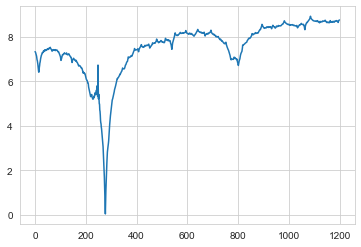

In [48]:

plt.plot(losses1)
plt.show()

In [49]:
lfo_freq_vals = np.linspace(0, 20, 100)

losses2 = []
for freq_val in lfo_freq_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(1, 1)]['parameters'].update({'freq': freq_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses2.append(loss_val.detach().cpu().numpy().item())

print(losses2)

[7.323907375335693, 1.4417402744293213, 1.4417402744293213, 1.1059386730194092, 0.0647369772195816, 1.166559100151062, 1.820888638496399, 1.9613603353500366, 2.0646181106567383, 2.2226719856262207, 2.3972315788269043, 2.6530556678771973, 2.685533285140991, 2.6945278644561768, 2.689666271209717, 2.8515989780426025, 3.0231714248657227, 3.0743792057037354, 3.021651029586792, 3.0086607933044434, 3.123283863067627, 3.146164655685425, 3.1889407634735107, 3.275182008743286, 3.2427802085876465, 3.2857422828674316, 3.3264405727386475, 3.3461451530456543, 3.5171501636505127, 3.3167409896850586, 3.485020160675049, 3.428828477859497, 3.6172144412994385, 3.5276708602905273, 3.4952800273895264, 3.51784348487854, 3.5450992584228516, 3.5637829303741455, 3.540792942047119, 3.5810184478759766, 3.576970100402832, 3.5374832153320312, 3.6039516925811768, 3.7868452072143555, 3.5782690048217773, 3.637406826019287, 3.7885446548461914, 3.5831098556518555, 3.713353157043457, 3.7469875812530518, 3.74367094039917

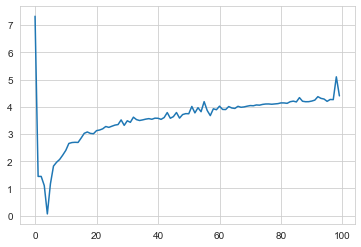

In [50]:
plt.plot(losses2)
plt.show()

In [31]:
amp_vals = np.linspace(0, 1, 100)

losses3 = []
for amp_val in amp_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'amp_c': amp_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses3.append(loss_val.detach().cpu().numpy().item())

print(losses3)


[6.136467933654785, 6.102036476135254, 6.03845739364624, 5.9634575843811035, 5.881933689117432, 5.796126842498779, 5.707270622253418, 5.616123199462891, 5.523195266723633, 5.428848743438721, 5.333352565765381, 5.236911296844482, 5.139686584472656, 5.04180383682251, 4.943365573883057, 4.844451904296875, 4.74513053894043, 4.6454548835754395, 4.545469284057617, 4.445209980010986, 4.344709396362305, 4.243990421295166, 4.143075466156006, 4.0419816970825195, 3.9407238960266113, 3.8393146991729736, 3.7377634048461914, 3.6360793113708496, 3.5342698097229004, 3.432340383529663, 3.3302958011627197, 3.2281408309936523, 3.12587833404541, 3.023510694503784, 2.9210407733917236, 2.8184690475463867, 2.7157974243164062, 2.6130268573760986, 2.5101571083068848, 2.407189130783081, 2.304121971130371, 2.200955629348755, 2.0976898670196533, 1.994323968887329, 1.8908565044403076, 1.787286639213562, 1.683613896369934, 1.5798358917236328, 1.4759520292282104, 1.3719605207443237, 1.2678601741790771, 1.16364848613

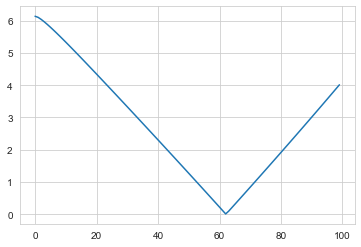

In [32]:
plt.plot(losses3)
plt.show()

In [33]:
mod_index_vals = np.linspace(0, 0.3, 1000)

losses4 = []
for mod_index_val in mod_index_vals:
    update_params = copy.deepcopy(target_param_dict)

    update_params[(0, 2)]['parameters'].update({'mod_index': mod_index_val})
    update_params[(1, 1)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'active': [True]})
    update_params[(0, 2)]['parameters'].update({'fm_active': [True]})
    synth.update_cells_from_dict(update_params)
    signal, _ = synth.generate_signal(signal_duration=1)

    # resampled_target_signal = resample_op(target_signal.cpu())
    # resampled_pred_signal = resample_op(signal.cpu())

    # plt.plot(resampled_target_signal.detach().numpy().squeeze())
    # plt.plot(resampled_pred_signal.detach().numpy().squeeze())
    #
    # plt.show()
    target_signal_unsqueezed = target_signal.unsqueeze(dim=0)
    loss_val, _, _ = loss_handler.call(target_signal_unsqueezed, signal, step=0, return_spectrogram=False)

    # loss_val = loss_handler.call(resampled_target_signal, resampled_pred_signal.unsqueeze(0), signal_chain_index=0, global_step=0, summary_writer=None, log=False)

    losses4.append(loss_val.detach().cpu().numpy().item())

print(losses4)

[7.898872375488281, 7.871593952178955, 7.948496341705322, 8.022019386291504, 7.914450645446777, 7.9410176277160645, 7.917671203613281, 7.920809268951416, 7.934653282165527, 7.952118873596191, 7.95267391204834, 8.020904541015625, 7.9150848388671875, 7.902811527252197, 7.959446907043457, 7.908353328704834, 7.897884845733643, 7.884659290313721, 7.932760238647461, 7.843234539031982, 7.82518196105957, 7.849972724914551, 7.855950832366943, 7.882440090179443, 7.905223846435547, 8.02312183380127, 7.952856063842773, 7.875982284545898, 7.866058826446533, 7.885161399841309, 7.832307815551758, 7.829174518585205, 7.876534938812256, 7.978798866271973, 7.911075592041016, 7.86004638671875, 7.959352016448975, 7.895684242248535, 7.954326152801514, 7.940317153930664, 7.917362213134766, 7.933131217956543, 7.898165702819824, 7.982824325561523, 7.804561138153076, 7.855087757110596, 7.840824604034424, 7.842255592346191, 7.806949615478516, 7.794468879699707, 7.769434928894043, 7.845434188842773, 7.75895786285

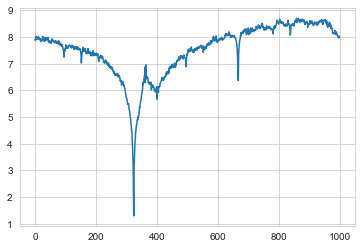

In [34]:
plt.plot(losses4)
plt.show()

In [8]:
sim_target_params = {'freq_c'}

In [9]:
spec_op = Spectrogram(n_fft=512)


fig, ax = plt.subplots(1, 2, figsize=(80, 40))

target_spec = spec_op(target_signal.cpu())

update_params = copy.deepcopy(target_param_dict)

update_params[(0,1)]['parameters'].update({'freq_c': 200})
synth.update_cells_from_dict(update_params)
signal, _ = synth.generate_signal()

pred_spec = spec_op(signal.cpu().detach())

ax[0].imshow(target_spec.squeeze(), origin='lower')
ax[1].imshow(pred_spec.squeeze(), origin='lower')

KeyError: (0, 1)